This notebook will describe experiments related to DUD-E

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt


import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master/hdpy")
# print(sys.path)
import hdpy
import hdpy.ecfp_hd
import hdpy.mole_hd
from hdpy.analysis import load_pkl


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


In [2]:
def compute_enrichment_factor(scores, labels, n_percent):
    # this variant implements the equation from Xiaohua's paper
    
    sample_n = int(np.ceil(n_percent * labels.shape[0]))
    
    sorted_scores = sorted(zip(scores, labels), key=lambda x: x[0], reverse=True)

    top_n_sorted_scores = sorted_scores[:sample_n]

    # counting number of true positives in top x% of sorted compounds
    actives_sampled = sum([y for x, y in top_n_sorted_scores])
    # labels are binary, sum to count number of actives
    actives_database = sum(labels)

    norm_factor = (sample_n/len(labels))

    return (actives_sampled / actives_database) * (labels.shape[0]/sample_n)


In [3]:
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/0")
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/4")
data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125")

range_limit = 10

# TODO: what is this directory (1) ?? (update) I think its a run that has openhd results
# data_p = Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/1")
# range_limit = 1


In [4]:
list(data_p.glob("dude.random*.pkl"))[0].name

'dude.random.hmdh.smiles-pe.bpe.0.pkl'

In [5]:
dude_target_names = list(set([x.name.split('.')[2] for x in list(data_p.glob("dude.random*.pkl"))]))
dude_target_names

['bace1',
 'comt',
 'pde5a',
 'pur2',
 'ada',
 'vgfr2',
 'hivrt',
 'pgh1',
 'esr1',
 'rxra',
 'thrb',
 'try1',
 'pgh2',
 'pygm',
 'aldr',
 'aces',
 'kith',
 'prgr',
 'fa10',
 'cdk2',
 'hivpr',
 'hmdh',
 'dyr',
 'pparg',
 'hs90a',
 'nram',
 'ace',
 'pnph',
 'mk14',
 'ampc',
 'andr',
 'egfr',
 'parp1',
 'inha',
 'mcr',
 'src',
 'gcr',
 'sahh']

In [6]:
def compute_average_enrichment(pkl_path, model):
    range_limit=10
    enrich_1_list = [] 
    enrich_10_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed

    
        if "openhd" in str(pkl_path):
            range_limit=1
        for seed in range(range_limit):
#             print(seed)

            if isinstance(data[seed]["y_true"], np.ndarray):
                y_true = data[seed]["y_true"]
            else:
                y_true = np.concatenate(data[seed]["y_true"]) 
            y_pred = np.array(data[seed]["y_pred"])

    
            eta = np.array(data[seed]["eta"])

            if np.unique(y_true).shape[0] < 2 :
                metric = 0
            else:
                metric = recall_score(y_pred=y_pred, y_true=y_true)
                if model in ["rf", "mlp"]:
                    eta= eta[:, 1]

            enrich_1 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.01)
            enrich_1_list.append(enrich_1)
                
            enrich_10 = compute_enrichment_factor(scores=eta, labels=y_true, n_percent=.1)
            enrich_10_list.append(enrich_10)
            
    
    return np.mean(enrich_1_list), np.std(enrich_1_list), np.mean(enrich_10_list), np.std(enrich_10_list)




def compute_average_train_time(pkl_path):
    print(pkl_path)
    train_time_list = []
    range_limit=10

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
        target = pkl_path.name.split(".")[2]
        split = pkl_path.name.split(".")[1]
        model = pkl_path.name.split(".")[3]

    
#         if "openhd" in model:
#             range_limit=1
        for seed in range(range_limit):

            train_time = -1
            if model in ["rf", "mlp"]:
                train_time  = data[seed]["train_time"]

            else:
                train_time = data[seed]["single_pass_train_time"]
                
                
                
            if "openhd" in model:
                pass
            
            elif "mlp" in model:
                train_time = train_time / 10 # trained MLP for max 10 epochs...check that it hits that but assume it didn't converge that quickly
            elif "rf" in model:
                train_time = train_time # there's no concept of epoch in a random forest
            else:
                train_time = train_time/10 # this should catch all HD models which were trained for 10 epochs per seed
            
            train_time_list.append(train_time)
            
            
    
    return np.mean(train_time_list)



def compute_average_inference_time(pkl_path):
    range_limit=10
    test_time_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        

    
#         if "openhd" in str(pkl_path):
#             range_limit=1
        for seed in range(range_limit):

            test_time  = data[seed]["test_time"]

            test_time_list.append(test_time)
            
            
    
    return np.mean(test_time_list)


def get_train_test_sizes(pkl_path):
    range_limit = 10
    train_size_list = []
    test_size_list = []
    

    with open(pkl_path, "rb") as handle:
        data = pickle.load(handle) # lets just use one seed
        
    
#         if "openhd" in str(pkl_path):
#             range_limit=1
        for seed in range(range_limit):

            train_size_list.append(data[seed]["train_size"])
            test_size_list.append(data[seed]["test_size"])            
            
    
    return np.mean(train_size_list), np.mean(test_size_list)
                    

# DUD-E results

In [7]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [8]:
#     "openhd-ecfp": green_color_pal[6],

color_dict = {
#     "smiles-pe.atomwise.0": rocket_color_pal[2],
#     "smiles-pe.bpe.0": rocket_color_pal[4],   
# "selfies.atomwise": green_color_pal[4],
#     "selfies.atomwise": green_color_pal[4],
    "ecfp": green_color_pal[6],
#     "rp": green_color_pal[8],
#     "rf": blue_color_pal[4],
#     "mlp": blue_color_pal[7],
}


model_order_list = [
    ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
    ("smiles-pe.bpe.0", "MoleHD-BPE"),
    ("selfies.atomwise", "HDBind-SELFIES"),
    ("ecfp", "HDBind-ECFP"),
    ("openhd-ecfp", "OpenHD-ECFP"),
    ("openhd-rp", "OpenHD-RPFP"),
    ("rp", "HDBind-RPFP"),
    ("rf", "RF"),
    ("mlp", "MLP"),
    ("Vina", "Vina")
]


model_name_dict = {
    "smiles-pe.atomwise.0": "MoleHD-Atomw.",
    "smiles-pe.bpe.0": "MoleHD-BPE",
    "selfies.atomwise": "HDBind-SELFIES",
    "ecfp": "HDBind-ECFP",
    "openhd-ecfp": "OPENHD-ECFP",
    "openhd-rp": "OPENHD-RPFP",
    "rp": "HDBind-RPFP",
    "rf": "RF",
    "mlp": "MLP",
    "Vina": "Vina"
 }

In [9]:
def aggregate_dude_results(dataset, split):
    
    model_metric_dict = {"model": [], "enrich-1-mean": [], 
                         "enrich-1-std":[], "enrich-10-mean": [], 
                         "enrich-10-std": [], 
#                          "train_time":[], 
                         "test_time": [],
                        "train_size": [], "test_size": []}
    

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]

    for model, color in color_dict.items():
                        
        data_path_list = list(data_p.glob(f"{dataset}.{split}.*.{model}*pkl"))

        
        for path in tqdm(data_path_list, total=len(data_path_list)):
            print(path)
            target = path.name.split(".")[2]
            split = path.name.split(".")[1]
            
                
                
            enrich_1_mean, enrich_1_std, enrich_10_mean, enrich_10_std = compute_average_enrichment(path, model=model)
#             train_time_mean = compute_average_train_time(path)
            test_time_mean = compute_average_inference_time(path)
            train_size, test_size = get_train_test_sizes(path)
            
            
            model_metric_dict["model"].append(model)
            model_metric_dict["enrich-1-mean"].append(enrich_1_mean)
            model_metric_dict["enrich-1-std"].append(enrich_1_std)
            model_metric_dict["enrich-10-mean"].append(enrich_10_mean)
            model_metric_dict["enrich-10-std"].append(enrich_10_std)
#             model_metric_dict["train_time"].append(train_time_mean)
            model_metric_dict["test_time"].append(test_time_mean)
            model_metric_dict["train_size"].append(train_size)
            model_metric_dict["test_size"].append(test_size)


    return enrich_f, enrich_1_ax, enrich_10_ax, model_metric_dict




  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.src.smiles-pe.atomwise.0.pkl


  3%|▎         | 1/38 [00:02<01:23,  2.27s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.kith.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.comt.smiles-pe.atomwise.0.pkl


  8%|▊         | 3/38 [00:02<00:23,  1.50it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivpr.smiles-pe.atomwise.0.pkl


 13%|█▎        | 5/38 [00:03<00:15,  2.10it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ampc.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aldr.smiles-pe.atomwise.0.pkl


 16%|█▌        | 6/38 [00:03<00:12,  2.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aces.smiles-pe.atomwise.0.pkl


 18%|█▊        | 7/38 [00:03<00:12,  2.43it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.bace1.smiles-pe.atomwise.0.pkl


 24%|██▎       | 9/38 [00:04<00:08,  3.24it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ada.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hs90a.smiles-pe.atomwise.0.pkl


 29%|██▉       | 11/38 [00:04<00:05,  4.78it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.sahh.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mk14.smiles-pe.atomwise.0.pkl


 34%|███▍      | 13/38 [00:05<00:07,  3.38it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hmdh.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.prgr.smiles-pe.atomwise.0.pkl


 37%|███▋      | 14/38 [00:05<00:06,  3.69it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.parp1.smiles-pe.atomwise.0.pkl


 39%|███▉      | 15/38 [00:06<00:08,  2.75it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.cdk2.smiles-pe.atomwise.0.pkl


 42%|████▏     | 16/38 [00:06<00:09,  2.37it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pde5a.smiles-pe.atomwise.0.pkl


 47%|████▋     | 18/38 [00:07<00:07,  2.82it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.andr.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mcr.smiles-pe.atomwise.0.pkl


 53%|█████▎    | 20/38 [00:07<00:04,  3.95it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.thrb.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.dyr.smiles-pe.atomwise.0.pkl


 61%|██████    | 23/38 [00:08<00:02,  5.08it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pur2.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pygm.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivrt.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pparg.smiles-pe.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:08<00:02,  4.79it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.rxra.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ace.smiles-pe.atomwise.0.pkl


 71%|███████   | 27/38 [00:09<00:02,  4.19it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.egfr.smiles-pe.atomwise.0.pkl


 74%|███████▎  | 28/38 [00:09<00:03,  2.71it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh2.smiles-pe.atomwise.0.pkl


 79%|███████▉  | 30/38 [00:10<00:02,  3.12it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.try1.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pnph.smiles-pe.atomwise.0.pkl


 82%|████████▏ | 31/38 [00:10<00:01,  3.57it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.fa10.smiles-pe.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:11<00:01,  3.27it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh1.smiles-pe.atomwise.0.pkl


 87%|████████▋ | 33/38 [00:11<00:01,  3.59it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.inha.smiles-pe.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.nram.smiles-pe.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:11<00:00,  4.92it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.vgfr2.smiles-pe.atomwise.0.pkl


 95%|█████████▍| 36/38 [00:11<00:00,  4.00it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.esr1.smiles-pe.atomwise.0.pkl


100%|██████████| 38/38 [00:12<00:00,  3.05it/s]


/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.gcr.smiles-pe.atomwise.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hmdh.smiles-pe.bpe.0.pkl


  3%|▎         | 1/38 [00:01<00:56,  1.54s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.dyr.smiles-pe.bpe.0.pkl


  5%|▌         | 2/38 [00:02<00:52,  1.46s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ampc.smiles-pe.bpe.0.pkl


  8%|▊         | 3/38 [00:03<00:44,  1.27s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pde5a.smiles-pe.bpe.0.pkl


 11%|█         | 4/38 [00:05<00:48,  1.44s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.andr.smiles-pe.bpe.0.pkl


 13%|█▎        | 5/38 [00:07<00:46,  1.41s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.esr1.smiles-pe.bpe.0.pkl


 16%|█▌        | 6/38 [00:08<00:46,  1.46s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh1.smiles-pe.bpe.0.pkl


 18%|█▊        | 7/38 [00:10<00:45,  1.47s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hs90a.smiles-pe.bpe.0.pkl


 21%|██        | 8/38 [00:11<00:42,  1.41s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.comt.smiles-pe.bpe.0.pkl


 24%|██▎       | 9/38 [00:12<00:37,  1.29s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pur2.smiles-pe.bpe.0.pkl


 26%|██▋       | 10/38 [00:13<00:32,  1.18s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivpr.smiles-pe.bpe.0.pkl


 29%|██▉       | 11/38 [00:15<00:38,  1.44s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ada.smiles-pe.bpe.0.pkl


 32%|███▏      | 12/38 [00:16<00:34,  1.31s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.bace1.smiles-pe.bpe.0.pkl


 34%|███▍      | 13/38 [00:18<00:35,  1.41s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivrt.smiles-pe.bpe.0.pkl


 37%|███▋      | 14/38 [00:18<00:29,  1.24s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.vgfr2.smiles-pe.bpe.0.pkl


 39%|███▉      | 15/38 [00:20<00:31,  1.38s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ace.smiles-pe.bpe.0.pkl


 42%|████▏     | 16/38 [00:22<00:32,  1.47s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh2.smiles-pe.bpe.0.pkl


 45%|████▍     | 17/38 [00:23<00:31,  1.49s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aces.smiles-pe.bpe.0.pkl


 47%|████▋     | 18/38 [00:25<00:31,  1.57s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.src.smiles-pe.bpe.0.pkl


 50%|█████     | 19/38 [00:27<00:31,  1.64s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.egfr.smiles-pe.bpe.0.pkl


 53%|█████▎    | 20/38 [00:29<00:31,  1.75s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.inha.smiles-pe.bpe.0.pkl


 55%|█████▌    | 21/38 [00:30<00:25,  1.48s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pnph.smiles-pe.bpe.0.pkl


 58%|█████▊    | 22/38 [00:31<00:21,  1.37s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.fa10.smiles-pe.bpe.0.pkl


 61%|██████    | 23/38 [00:32<00:21,  1.42s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.thrb.smiles-pe.bpe.0.pkl


 63%|██████▎   | 24/38 [00:34<00:20,  1.44s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.gcr.smiles-pe.bpe.0.pkl


 66%|██████▌   | 25/38 [00:35<00:18,  1.43s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aldr.smiles-pe.bpe.0.pkl


 68%|██████▊   | 26/38 [00:36<00:16,  1.37s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pparg.smiles-pe.bpe.0.pkl


 71%|███████   | 27/38 [00:38<00:16,  1.48s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.cdk2.smiles-pe.bpe.0.pkl


 74%|███████▎  | 28/38 [00:40<00:15,  1.55s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mcr.smiles-pe.bpe.0.pkl


 76%|███████▋  | 29/38 [00:41<00:12,  1.38s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.parp1.smiles-pe.bpe.0.pkl


 79%|███████▉  | 30/38 [00:43<00:11,  1.48s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pygm.smiles-pe.bpe.0.pkl


 82%|████████▏ | 31/38 [00:44<00:09,  1.38s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.rxra.smiles-pe.bpe.0.pkl


 84%|████████▍ | 32/38 [00:45<00:07,  1.27s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.try1.smiles-pe.bpe.0.pkl


 87%|████████▋ | 33/38 [00:46<00:06,  1.31s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.prgr.smiles-pe.bpe.0.pkl


 89%|████████▉ | 34/38 [00:47<00:05,  1.30s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.nram.smiles-pe.bpe.0.pkl


 92%|█████████▏| 35/38 [00:49<00:03,  1.27s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mk14.smiles-pe.bpe.0.pkl


 95%|█████████▍| 36/38 [00:51<00:02,  1.44s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.kith.smiles-pe.bpe.0.pkl


 97%|█████████▋| 37/38 [00:52<00:01,  1.33s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.sahh.smiles-pe.bpe.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.vgfr2.selfies.atomwise.0.pkl


  3%|▎         | 1/38 [00:00<00:16,  2.25it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh2.selfies.atomwise.0.pkl


  5%|▌         | 2/38 [00:00<00:14,  2.43it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.thrb.selfies.atomwise.0.pkl


 11%|█         | 4/38 [00:01<00:08,  4.03it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ada.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.src.selfies.atomwise.0.pkl


 13%|█▎        | 5/38 [00:01<00:12,  2.56it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.cdk2.selfies.atomwise.0.pkl


 16%|█▌        | 6/38 [00:02<00:14,  2.23it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.dyr.selfies.atomwise.0.pkl


 18%|█▊        | 7/38 [00:02<00:12,  2.47it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pur2.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.andr.selfies.atomwise.0.pkl


 26%|██▋       | 10/38 [00:03<00:06,  4.06it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pnph.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.nram.selfies.atomwise.0.pkl


 29%|██▉       | 11/38 [00:03<00:05,  4.53it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.egfr.selfies.atomwise.0.pkl


 32%|███▏      | 12/38 [00:03<00:09,  2.84it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh1.selfies.atomwise.0.pkl


 34%|███▍      | 13/38 [00:04<00:07,  3.17it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.esr1.selfies.atomwise.0.pkl


 39%|███▉      | 15/38 [00:04<00:06,  3.78it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.sahh.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.inha.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aldr.selfies.atomwise.0.pkl


 45%|████▍     | 17/38 [00:04<00:04,  4.74it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.prgr.selfies.atomwise.0.pkl


 50%|█████     | 19/38 [00:05<00:03,  5.28it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pygm.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hs90a.selfies.atomwise.0.pkl


 55%|█████▌    | 21/38 [00:05<00:02,  5.91it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.rxra.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aces.selfies.atomwise.0.pkl


 61%|██████    | 23/38 [00:06<00:03,  4.76it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ampc.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivpr.selfies.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:06<00:03,  3.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hmdh.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.fa10.selfies.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:07<00:03,  3.17it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.bace1.selfies.atomwise.0.pkl


 71%|███████   | 27/38 [00:07<00:03,  3.12it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.gcr.selfies.atomwise.0.pkl


 74%|███████▎  | 28/38 [00:07<00:02,  3.50it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pde5a.selfies.atomwise.0.pkl


 76%|███████▋  | 29/38 [00:08<00:03,  2.92it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ace.selfies.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:08<00:01,  4.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivrt.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.kith.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.try1.selfies.atomwise.0.pkl


 87%|████████▋ | 33/38 [00:09<00:01,  4.60it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mk14.selfies.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:09<00:00,  3.63it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.comt.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mcr.selfies.atomwise.0.pkl
/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.parp1.selfies.atomwise.0.pkl


 97%|█████████▋| 37/38 [00:10<00:00,  3.36it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pparg.selfies.atomwise.0.pkl


  0%|          | 0/38 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aldr.ecfp.atomwise.0.pkl


  3%|▎         | 1/38 [00:01<01:03,  1.71s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.gcr.ecfp.atomwise.0.pkl


  5%|▌         | 2/38 [00:02<00:39,  1.11s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pparg.ecfp.atomwise.0.pkl


  8%|▊         | 3/38 [00:03<00:37,  1.06s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.thrb.ecfp.atomwise.0.pkl


 11%|█         | 4/38 [00:04<00:31,  1.10it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.fa10.ecfp.atomwise.0.pkl


 13%|█▎        | 5/38 [00:04<00:29,  1.12it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mcr.ecfp.atomwise.0.pkl


 16%|█▌        | 6/38 [00:05<00:26,  1.20it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.cdk2.ecfp.atomwise.0.pkl


 18%|█▊        | 7/38 [00:06<00:27,  1.11it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.aces.ecfp.atomwise.0.pkl


 21%|██        | 8/38 [00:07<00:27,  1.09it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.egfr.ecfp.atomwise.0.pkl


 24%|██▎       | 9/38 [00:08<00:28,  1.00it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.src.ecfp.atomwise.0.pkl


 26%|██▋       | 10/38 [00:09<00:28,  1.04s/it]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pnph.ecfp.atomwise.0.pkl


 29%|██▉       | 11/38 [00:10<00:26,  1.02it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.inha.ecfp.atomwise.0.pkl


 32%|███▏      | 12/38 [00:11<00:22,  1.17it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.kith.ecfp.atomwise.0.pkl


 34%|███▍      | 13/38 [00:11<00:19,  1.28it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.mk14.ecfp.atomwise.0.pkl


 37%|███▋      | 14/38 [00:13<00:21,  1.12it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.nram.ecfp.atomwise.0.pkl


 39%|███▉      | 15/38 [00:13<00:18,  1.22it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.prgr.ecfp.atomwise.0.pkl


 42%|████▏     | 16/38 [00:14<00:18,  1.20it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.sahh.ecfp.atomwise.0.pkl


 45%|████▍     | 17/38 [00:15<00:16,  1.31it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.try1.ecfp.atomwise.0.pkl


 47%|████▋     | 18/38 [00:15<00:14,  1.35it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.rxra.ecfp.atomwise.0.pkl


 50%|█████     | 19/38 [00:16<00:13,  1.40it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.parp1.ecfp.atomwise.0.pkl


 53%|█████▎    | 20/38 [00:17<00:14,  1.23it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pygm.ecfp.atomwise.0.pkl


 55%|█████▌    | 21/38 [00:18<00:13,  1.25it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hs90a.ecfp.atomwise.0.pkl


 58%|█████▊    | 22/38 [00:19<00:12,  1.32it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh1.ecfp.atomwise.0.pkl


 61%|██████    | 23/38 [00:19<00:11,  1.34it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.andr.ecfp.atomwise.0.pkl


 63%|██████▎   | 24/38 [00:20<00:10,  1.39it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.esr1.ecfp.atomwise.0.pkl


 66%|██████▌   | 25/38 [00:21<00:09,  1.32it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pur2.ecfp.atomwise.0.pkl


 68%|██████▊   | 26/38 [00:22<00:09,  1.33it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.comt.ecfp.atomwise.0.pkl


 71%|███████   | 27/38 [00:22<00:07,  1.41it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ampc.ecfp.atomwise.0.pkl


 74%|███████▎  | 28/38 [00:23<00:06,  1.47it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hmdh.ecfp.atomwise.0.pkl


 76%|███████▋  | 29/38 [00:23<00:06,  1.47it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.dyr.ecfp.atomwise.0.pkl


 79%|███████▉  | 30/38 [00:24<00:05,  1.39it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pde5a.ecfp.atomwise.0.pkl


 82%|████████▏ | 31/38 [00:25<00:05,  1.18it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.vgfr2.ecfp.atomwise.0.pkl


 84%|████████▍ | 32/38 [00:26<00:05,  1.16it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivrt.ecfp.atomwise.0.pkl


 87%|████████▋ | 33/38 [00:27<00:03,  1.28it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh2.ecfp.atomwise.0.pkl


 89%|████████▉ | 34/38 [00:28<00:03,  1.24it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ace.ecfp.atomwise.0.pkl


 92%|█████████▏| 35/38 [00:29<00:02,  1.16it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.hivpr.ecfp.atomwise.0.pkl


 95%|█████████▍| 36/38 [00:30<00:01,  1.06it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.bace1.ecfp.atomwise.0.pkl


 97%|█████████▋| 37/38 [00:31<00:00,  1.09it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.ada.ecfp.atomwise.0.pkl


  0%|          | 0/10 [00:00<?, ?it/s]

/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/125/dude.random.pgh2.rp.atomwise.0.pkl


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

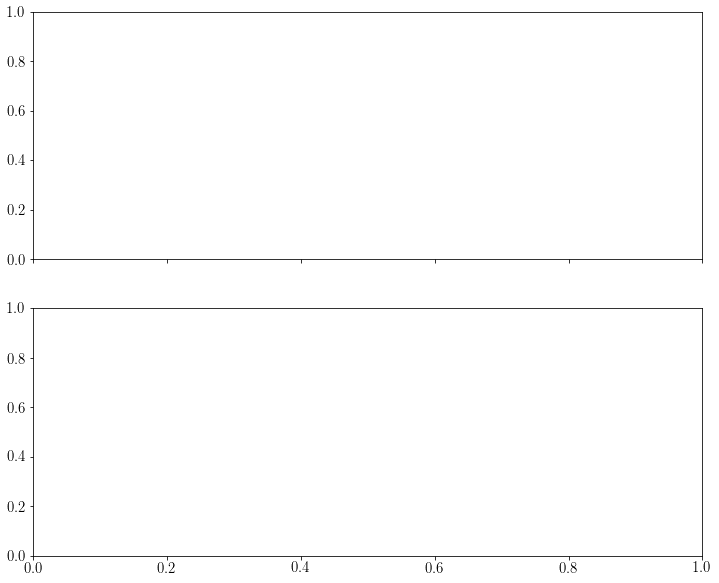

In [10]:
dude_enrich_f, dude_enrich_1_ax, dude_enrich_10_ax, model_metric_dict = aggregate_dude_results(dataset="dude", split="random")


In [ ]:
model_metric_dict.keys()

In [ ]:
[(x[0], len(x[1])) for x in model_metric_dict.items()]

In [ ]:
model_metric_df = pd.DataFrame(model_metric_dict)

# for col in model_metric_df.columns:
#     model_model_metric_df[col].apply(lambda x: x[0])
#     model_metric_df[col].apply(lambda x: x[1])
#     model_metric_df[col].apply(lambda x: x[2])
    
# model_metric_df_list = [pd.DataFrame({"metric": [tup[0] for tup in model_metric_df[col].values],
#                                       "enrich-1": [tup[1] for tup in model_metric_df[col].values],
#                                       "enrich-10": [tup[2] for tup in model_metric_df[col].values]
#                                       "model": [col]*len(model_metric_df)} for col in model_metric_df.columns)]


# model_metric_df = pd.concat(model_metric_df_list)

# model_metric_df["latency"] = model_metric_df["test_time"] / model_metric_df["test_size"]

model_metric_df


In [ ]:
# model_metric_df['enrich-1'] = model_metric_df['enrich-1'].apply(lambda x: float(np.array(x)))
# model_metric_df['enrich-10'] = model_metric_df['enrich-10'].apply(lambda x: float(np.array(x)))

## Vina Docking baseline

In [ ]:
vina_root_p = Path("/p/lustre1/jones289/DUDE-38/")


color_dict.update({"Vina": "salmon"})



vina_path_list = [path for path in vina_root_p.glob("*-active-summary.txt")]


df_list = []


# root_dude_dir = Path("/g/g13/jones289/workspace/hd-cuda-master/datasets/dude/dude_smiles/")
root_dude_dir = Path("/usr/workspace/atom/gbsa_modeling/dude_smiles/")
for idx, path in  enumerate(vina_path_list):
#     print(idx, path)
    target = path.name.split(".")[0].split("-")[0]
    print(target, idx+1, path)
    
    # for some reason don't have inactive data for abl1
    if target in ["abl1"]:
        continue
    if target in dude_target_names:
    
        active_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-active-summary.txt", header=None, delim_whitespace=True)
        active_df['y_true'] = [1] * len(active_df)
    
        decoy_df = pd.read_csv(f"/p/lustre1/jones289/DUDE-38/{target}-decoy-summary.txt", header=None, delim_whitespace=True)
        decoy_df['y_true'] = [0] * len(decoy_df)
    
    
        target_df = pd.concat([active_df, decoy_df])
        
        target_df["target"] = [target] * len(target_df)
    
        target_df["vina"] = target_df[2]
        target_df["gbsa"] = target_df[3]
        
        target_df["cmpd_id"] = target_df[1]
        
        target_df["target_size"] = target_df.shape[0]
        
#         import pdb
#         pdb.set_trace()
        random_split_df = pd.read_csv(root_dude_dir/ Path(f"{target}_gbsa_smiles_with_base_rdkit_smiles_train_valid_test_random_random.csv"))
        
        
#         import pdb
#         pdb.set_trace()

        # we only use the scores from the test set to attempt an even comparison
    
        merged_df = pd.merge(target_df, random_split_df, on="cmpd_id")
        merged_df = merged_df.loc[merged_df['subset'] == "test"]

        print(merged_df.shape)
    
        df_list.append(merged_df)
    else:
        pass

df = pd.concat(df_list)
    

In [ ]:
set(df['target'].values.tolist())

In [ ]:
df

In [ ]:
target_size_list = []
vina_enrich_1_list = []
vina_enrich_10_list = []

for target, target_df in df.groupby("target"):
    
    ef_1 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.01)
    ef_10 = compute_enrichment_factor(scores=np.abs(target_df["vina"]), labels=target_df["y_true"], n_percent=0.1)

    
    target_size_list.append(target_df.shape[0])
    
    vina_enrich_1_list.append(ef_1)
    vina_enrich_10_list.append(ef_10)
    
    
    print(f"{target}, {ef_1:.4f}\t{ef_10:.4f}\t{target_df.shape[0]}")
    
sorted_vina_enrich_1_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_1_list), key=lambda pair: pair[0])]
sorted_vina_enrich_10_list = [x for _, x in sorted(zip(target_size_list, vina_enrich_10_list), key=lambda pair: pair[0])]



I think it would be good to move away from the per-target (sorted by size) scatter plot and instead make a series of box plots...this should make it easier to compare the enrichment factors as you increase the amount of data that you are allowed to screen

In [ ]:
model_metric_df = pd.concat([model_metric_df, pd.DataFrame({"metric": [0]*38, "enrich-1-mean": sorted_vina_enrich_1_list, 
                                            "enrich-10-mean": sorted_vina_enrich_10_list,
                                          "model": ["Vina"]*38, 
                                                           })])


model_metric_df

In [ ]:
sns.boxplot(data=model_metric_df[model_metric_df["model"].apply(lambda x: "openhd" not in x.lower())], x="model", y="enrich-1-mean", ax=dude_enrich_1_ax, palette=color_dict)
# dude_enrich_1_ax.set_title("(a) DUD-E Enrichment at 1\%", fontdict={"fontsize": 18})
dude_enrich_1_ax.tick_params(axis="x", labelrotation=22.5)
dude_enrich_1_ax.set_xlabel("")
dude_enrich_1_ax.set_ylabel("EF")

# labels = [x[1] for x in model_order_list]

# dude_enrich_1_ax.set_xticklabels(labels)


In [ ]:
sns.boxplot(data=model_metric_df[model_metric_df["model"].apply(lambda x: "openhd" not in x.lower())], x="model", y="enrich-10-mean", ax=dude_enrich_10_ax, palette=color_dict)
# dude_enrich_10_ax.set_title("(b) DUD-E Enrichment at 10\%", fontdict={"fontsize": 18})

dude_enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
# dude_enrich_10_ax.tick_params(axis="y")
dude_enrich_10_ax.set_xlabel("")
dude_enrich_10_ax.set_ylabel("EF")

labels = [model_name_dict[x.get_text()] for x in dude_enrich_10_ax.get_xticklabels()]
dude_enrich_10_ax.set_xticklabels(labels)


# # dude_enrich_10_ax.set_xticklabels(labels)
# plt.tight_layout()
dude_enrich_f.savefig("dude_enrich.png", dpi=600, bbox_inches="tight")


In [ ]:
dude_enrich_f

In [ ]:
model_metric_df[model_metric_df['model'] == "rp"].shape
for group_name, group_df in model_metric_df.groupby("model"):
    print(group_df.shape)

In [ ]:
model_metric_df.groupby('model').describe()[['enrich-1-mean', 'enrich-10-mean']]

In [ ]:
model_metric_df.groupby('model').describe()[['enrich-1-std', 'enrich-10-std']]

In [ ]:
# model_metric_df.groupby('model').describe()['latency']['mean']['ecfp'] +\
# model_metric_df.groupby('model').describe()['latency']['mean']['rp'] +\
# model_metric_df.groupby('model').describe()['latency']['mean']['ecfp']

# OpenHD speedup

for now (03/15/23), the current openhd results are stored here: 

In [ ]:
model_metric_df

In [ ]:
model_metric_df["latency_per_mol"] = model_metric_df.apply(lambda x: x["test_time"]/x["test_size"], axis=1)

In [ ]:
model_metric_df[model_metric_df["model"] == "mlp"]

In [ ]:
model_metric_df[model_metric_df["model"] == "ecfp"]

In [ ]:
for group_name, group_df in model_metric_df.groupby("model"):
    print(group_name, group_df.shape)


In [ ]:
f, ax = plt.subplots(1,1, figsize=(14,8))

# for group_name, group_df in model_metric_df.groupby("model"):
#     sns.boxplot(data=group_df, x="train_time", ax=ax)
g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="train_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [ ]:
group_dict = {group_name: group_df for group_name, group_df in model_metric_df.groupby('model')}

In [ ]:
# group_dict["rp"]["train_time"].mean() / group_dict["openhd-rp"]["train_time"].mean()

In [ ]:
# group_dict["ecfp"]["train_time"].mean() / group_dict["openhd-ecfp"]["train_time"].mean()

In [ ]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="test_time", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [ ]:
# sns.lineplot(data=model_metric_df, x="model", y="test_time")

In [ ]:
group_dict["rf"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

In [ ]:
group_dict["mlp"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

In [ ]:
group_dict["ecfp"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

In [ ]:
# group_dict["openhd-ecfp"]["test_time"].mean() / group_dict["rf"]["test_size"].mean()

In [ ]:
f, ax = plt.subplots(1,1, figsize=(14,8))

g = sns.boxplot(data=model_metric_df[model_metric_df["model"] != "Vina"], x="model", y="latency_per_mol", ax=ax, palette=color_dict)
ax.tick_params(axis="x", labelrotation=22.5)
g.set_yscale("log")

In [ ]:
group_dict["ecfp"]["test_time"].mean() / group_dict["openhd-ecfp"]["test_time"].mean()

In [ ]:
group_dict["rp"]["test_time"].mean() / group_dict["openhd-rp"]["test_time"].mean()

In [ ]:
group_dict["rp"]["test_time"].mean()

In [ ]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['train_time'].mean()}")

In [ ]:
for group_name in group_dict.keys():
    print(f"{group_name}-{group_dict[group_name]['test_time'].mean()}")